In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy import stats as sp_stats
from scipy.stats import linregress
df_total = pd.read_csv("../data/steamspy_enriched.csv")
df_enriched=df_total


 TENDENCIA:
 Precios SUBEN $0.36 por año (promedio)
   R² = 0.26 (26% de varianza explicada)


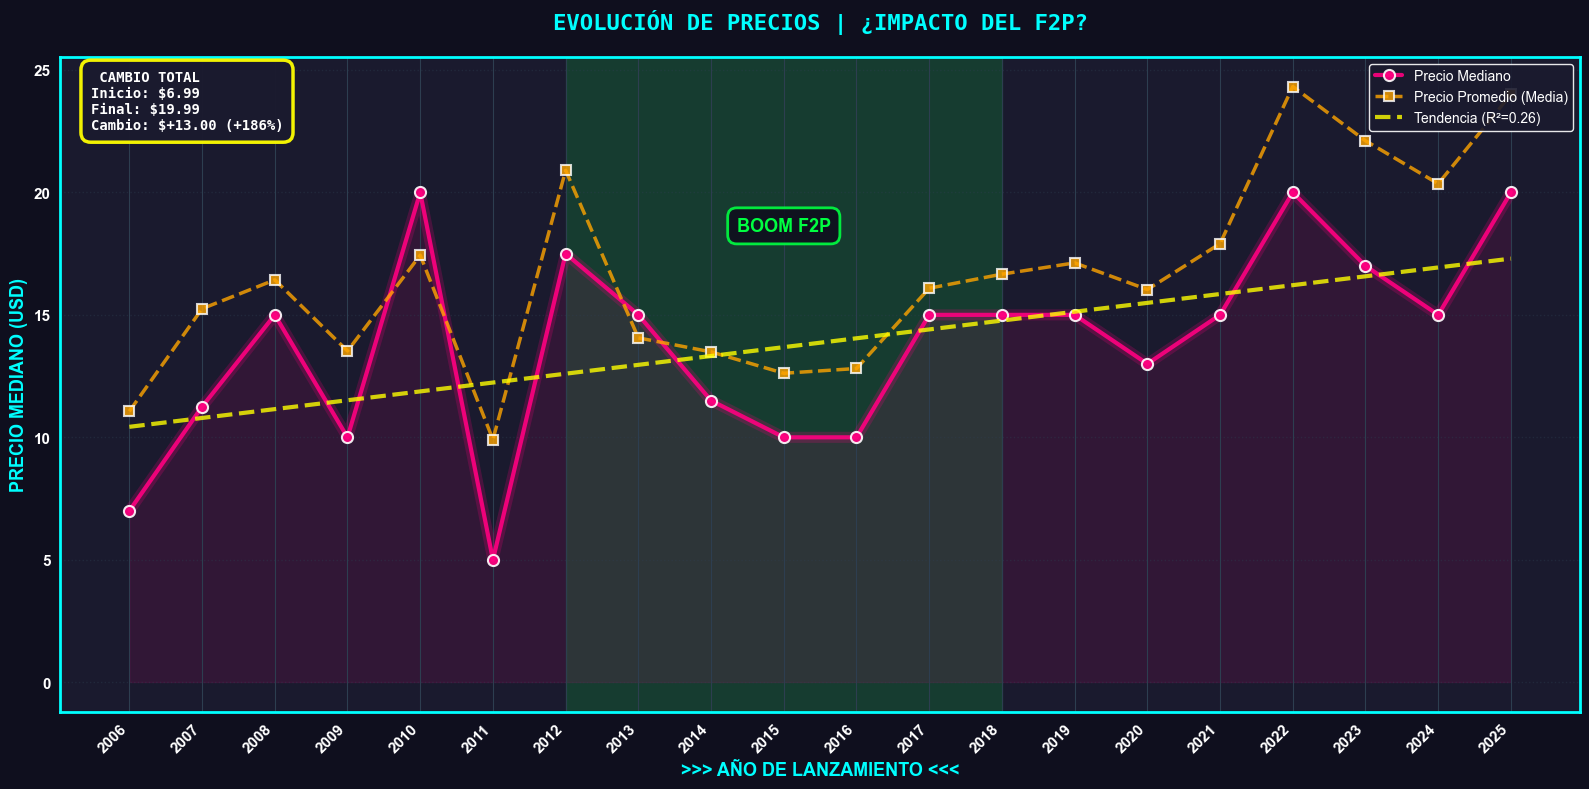

In [2]:
# Estilo gaming
plt.style.use('dark_background')
sns.set_style("darkgrid", {
    "axes.facecolor": "#1a1a2e",
    "figure.facecolor": "#0f0f1e",
    "grid.color": "#2d3e50",
    "grid.alpha": 0.3
})
COLOR_F2P = '#00ff41'
COLOR_PAID = '#ff0080'
COLOR_TEXT = '#00ffff'

# Preparamos los datos
# Convertir precio a USD
df_total['price_usd'] = df_total['price'] / 100

# Filtrar solo Paid y excluir muy caros
df_paid = df_total[
    (df_total['price_usd'] > 0) & 
    (df_total['price_usd'] <= 100)
].copy()

# Asegurar release_year sin nulos
df_paid['release_year'] = pd.to_datetime(df_paid['release_date'], errors='coerce').dt.year
df_paid = df_paid[df_paid['release_year'].notna()]

# Agrupar por año y calcular estadísticas
price_by_year = df_paid.groupby('release_year').agg({
    'price_usd': ['median', 'mean', 'count']
}).reset_index()
price_by_year.columns = ['release_year', 'price_median', 'price_mean', 'n_games']

# Filtrar años con al menos 5 juegos
price_by_year = price_by_year[price_by_year['n_games'] >= 5]

# Estadística (Regresión lineal)
X = price_by_year['release_year'].values
y_median = price_by_year['price_median'].values
slope, intercept, r_value, p_value, std_err = linregress(X, y_median)
y_pred = slope * X + intercept

print(f"\n TENDENCIA:")
if slope < -0.01:
    print(f" Precios BAJAN ${abs(slope):.2f} por año (promedio)")
elif slope > 0.01:
    print(f" Precios SUBEN ${slope:.2f} por año (promedio)")
else:
    print(f"   → Precios ESTABLES (variación mínima)")
print(f"   R² = {r_value**2:.2f} ({r_value**2*100:.0f}% de varianza explicada)")

# Gráfico
fig, ax = plt.subplots(figsize=(16, 8))

# Zona boom F2P
if price_by_year['release_year'].min() <= 2012 and price_by_year['release_year'].max() >= 2018:
    ax.axvspan(2012, 2018, alpha=0.15, color=COLOR_F2P, zorder=0)
    ax.text(2015, price_by_year['price_median'].max() * 0.95, 
            'BOOM F2P', ha='center', va='top', fontsize=13,
            color=COLOR_F2P, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#0f0f1e',
                     edgecolor=COLOR_F2P, linewidth=2, alpha=0.9))

# Línea mediana (principal)
ax.plot(price_by_year['release_year'], price_by_year['price_median'],
        marker='o', linewidth=3, color=COLOR_PAID, markersize=8,
        markeredgecolor='white', markeredgewidth=1.5, 
        label='Precio Mediano', alpha=0.9, zorder=3)

# Efecto glow
ax.plot(price_by_year['release_year'], price_by_year['price_median'],
        linewidth=8, color=COLOR_PAID, alpha=0.2, zorder=2)

# Línea media
ax.plot(price_by_year['release_year'], price_by_year['price_mean'],
        marker='s', linewidth=2.5, color='orange', markersize=7,
        markeredgecolor='white', markeredgewidth=1.5, 
        label='Precio Promedio (Media)', alpha=0.8, linestyle='--', zorder=3)

# Línea de regresión
ax.plot(X, y_pred, color='yellow', linewidth=3, linestyle='--',
        alpha=0.8, label=f'Tendencia (R²={r_value**2:.2f})', zorder=4)

# Área bajo curva
ax.fill_between(price_by_year['release_year'], 0, price_by_year['price_median'],
                alpha=0.1, color=COLOR_PAID, zorder=0)

# Cuadro con estadísticas simples
cambio_total = price_by_year['price_median'].iloc[-1] - price_by_year['price_median'].iloc[0]
cambio_pct = (cambio_total / price_by_year['price_median'].iloc[0]) * 100
stats_text = (f" CAMBIO TOTAL\n"
              f"Inicio: ${price_by_year['price_median'].iloc[0]:.2f}\n"
              f"Final: ${price_by_year['price_median'].iloc[-1]:.2f}\n"
              f"Cambio: ${cambio_total:+.2f} ({cambio_pct:+.0f}%)")
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='#1a1a2e',
                 edgecolor='yellow', linewidth=2.5, alpha=0.95),
        color='white', fontweight='bold', family='monospace')

# Título y labels (estilo del primero)
ax.set_title('EVOLUCIÓN DE PRECIOS | ¿IMPACTO DEL F2P?',
             fontsize=16, fontweight='bold', color=COLOR_TEXT,
             family='monospace', pad=20)
ax.set_xlabel('>>> AÑO DE LANZAMIENTO <<<', fontsize=13,
              color=COLOR_TEXT, fontweight='bold')
ax.set_ylabel('PRECIO MEDIANO (USD)', fontsize=13,
              color=COLOR_TEXT, fontweight='bold')

# Leyenda (estilo del primero)
legend = ax.legend(loc='upper right', fontsize=10, framealpha=0.9,
                   facecolor='#1a1a2e', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Ticks (estilo del primero)
ax.tick_params(axis='both', labelsize=11, colors='white')

# FORZAR AÑOS COMO ENTEROS (sin decimales)
years_to_show = price_by_year['release_year'].astype(int).values
ax.set_xticks(years_to_show)
ax.set_xticklabels(years_to_show, rotation=45, ha='right')

for label in ax.get_xticklabels():
    label.set_color('white')
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_color('white')
    label.set_fontweight('bold')

# Grid y spines (estilo del primero)
ax.grid(True, linestyle=':', linewidth=1, alpha=0.4, axis='y')
for spine in ax.spines.values():
    spine.set_edgecolor(COLOR_TEXT)
    spine.set_linewidth(2)

plt.tight_layout()
plt.show();

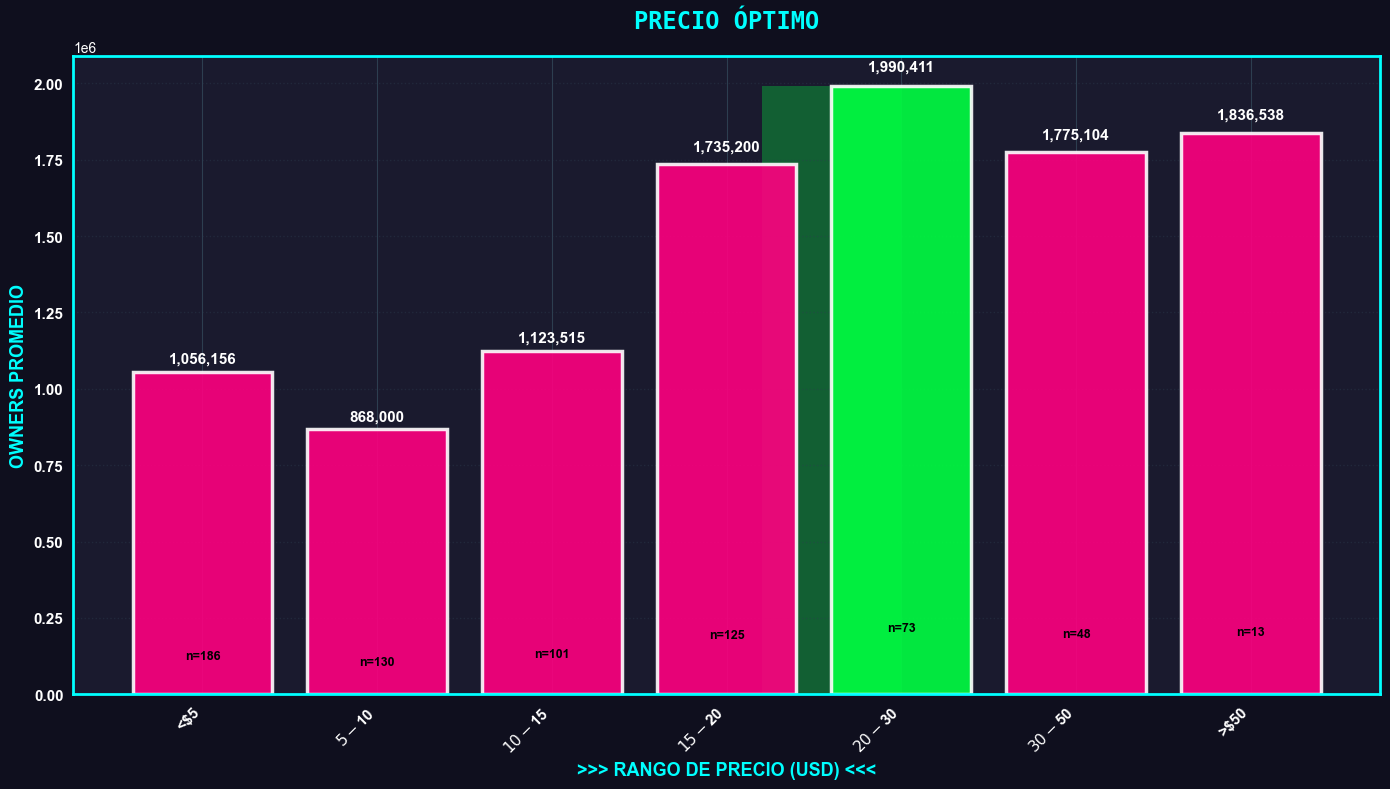

In [3]:
# Estilo gaming
plt.style.use('dark_background')
sns.set_style("darkgrid", {
    "axes.facecolor": "#1a1a2e",
    "figure.facecolor": "#0f0f1e",
    "grid.color": "#2d3e50",
    "grid.alpha": 0.3
})
COLOR_F2P = '#00ff41'
COLOR_PAID = '#ff0080'
COLOR_TEXT = '#00ffff'
# Preparamos los datos
# Convertir precio a USD
df_total['price_usd'] = df_total['price'] / 100
# Filtrar solo Paid y excluir muy caros
df_paid = df_total[
    (df_total['price_usd'] > 0) & 
    (df_total['price_usd'] <= 100) &
    (df_total['owners_median'] > 0)
].copy()
# Categorizar precios
bins = [0, 5, 10, 15, 20, 30, 50, 100]
labels = ['<$5', '$5-$10', '$10-$15', '$15-$20', '$20-$30', '$30-$50', '>$50']
df_paid['price_category'] = pd.cut(df_paid['price_usd'], bins=bins, labels=labels)
# Agrupar por categoría
price_analysis = df_paid.groupby('price_category', observed=True).agg({
    'owners_median': ['mean', 'median', 'count']
}).reset_index()
price_analysis.columns = ['category', 'owners_mean', 'owners_median', 'n_games']
# Identificar sweet spot
sweet_spot_idx = price_analysis['owners_mean'].idxmax()
sweet_spot = price_analysis.loc[sweet_spot_idx, 'category']
#Gráfico
fig, ax = plt.subplots(figsize=(14, 8))
# Barras principales
colors = [COLOR_F2P if i == sweet_spot_idx else COLOR_PAID 
          for i in range(len(price_analysis))]
bars = ax.bar(price_analysis['category'], price_analysis['owners_mean'],
              color=colors, edgecolor='white', linewidth=2.5, alpha=0.9)
# Efecto glow en sweet spot
sweet_spot_bar = bars[sweet_spot_idx]
ax.bar(sweet_spot_bar.get_x(), sweet_spot_bar.get_height(), 
       sweet_spot_bar.get_width(), color=COLOR_F2P, alpha=0.3, linewidth=0, zorder=0)
# Valores encima de barras
for bar, row in zip(bars, price_analysis.itertuples()):
    height = bar.get_height()    
    # Valor owners
    ax.text(bar.get_x() + bar.get_width()/2, height + height*0.02,
            f'{row.owners_mean:,.0f}',
            ha='center', va='bottom', fontsize=11,
            color='white', fontweight='bold')    
    # Número de juegos
    ax.text(bar.get_x() + bar.get_width()/2, height*0.1,
            f'n={row.n_games:,}',
            ha='center', va='bottom', fontsize=9,
            color='black', fontweight='bold')
# Título y labels
ax.set_title('PRECIO ÓPTIMO',
             fontsize=17, fontweight='bold', color=COLOR_TEXT,
             family='monospace', pad=20)
ax.set_xlabel('>>> RANGO DE PRECIO (USD) <<<', fontsize=13,
              color=COLOR_TEXT, fontweight='bold')
ax.set_ylabel('OWNERS PROMEDIO', fontsize=13,
              color=COLOR_TEXT, fontweight='bold')
# Ticks en blanco
ax.tick_params(axis='both', labelsize=11, colors='white')
for label in ax.get_xticklabels():
    label.set_color('white')
    label.set_fontweight('bold')
    label.set_rotation(45)
    label.set_ha('right')
for label in ax.get_yticklabels():
    label.set_color('white')
    label.set_fontweight('bold')
# Grid y spines
ax.grid(True, linestyle=':', linewidth=1, alpha=0.4, axis='y')
for spine in ax.spines.values():
    spine.set_edgecolor(COLOR_TEXT)
    spine.set_linewidth(2)

plt.tight_layout()
plt.show();

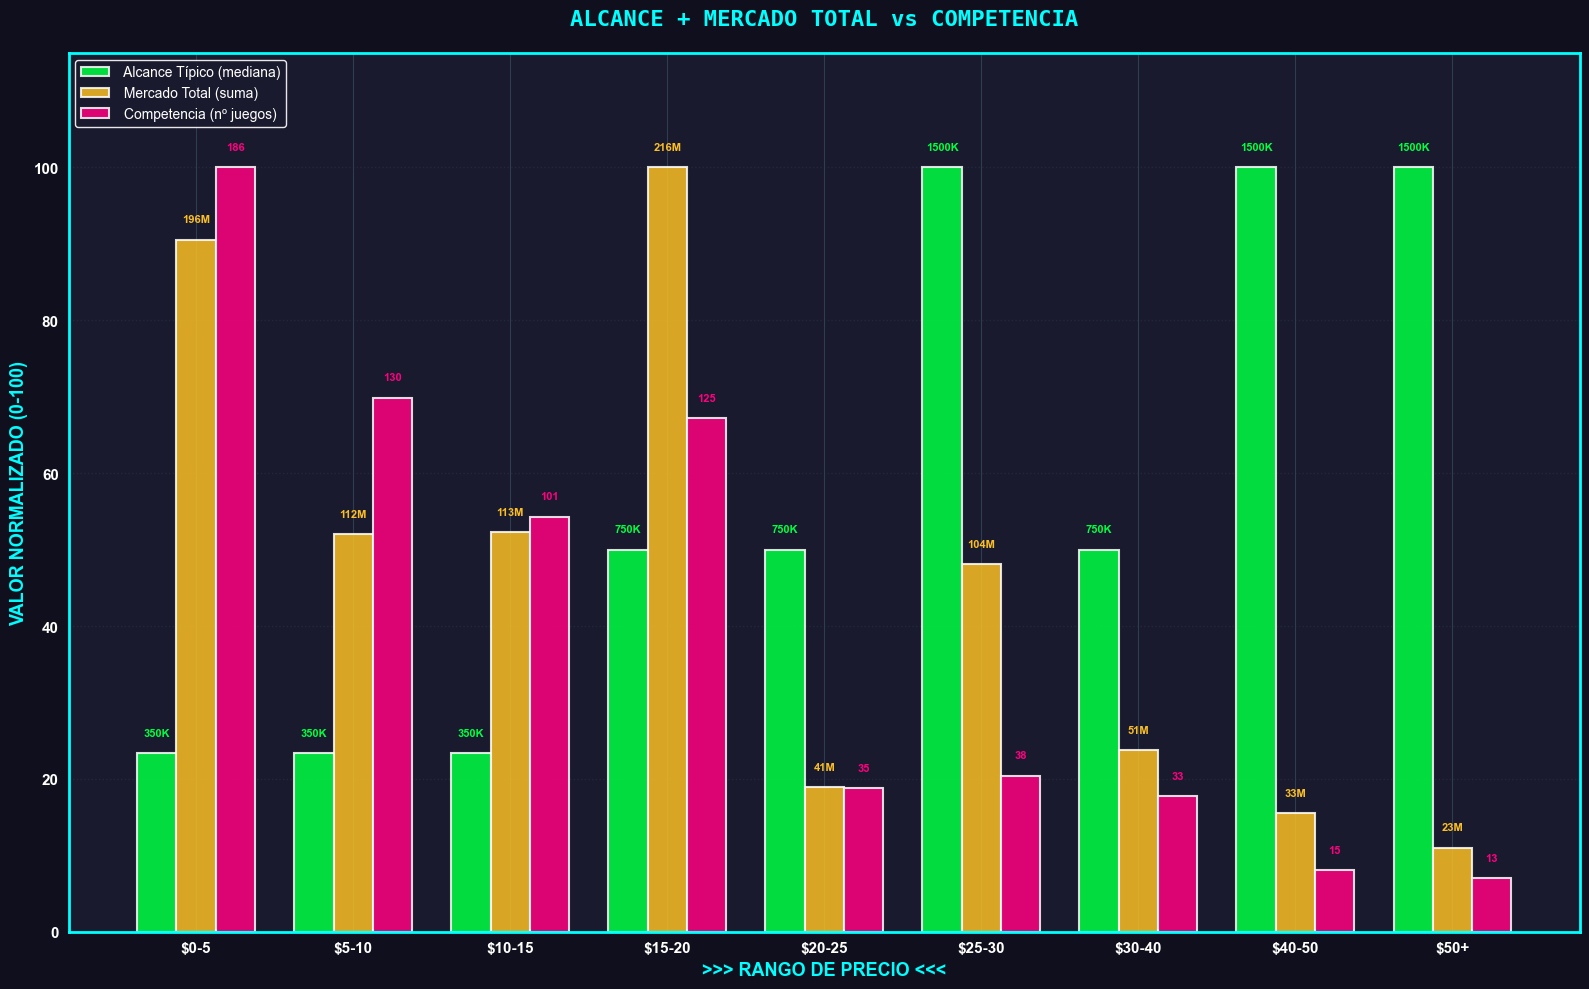

In [4]:
# Estilo gaming
plt.style.use('dark_background')
sns.set_style("darkgrid", {
    "axes.facecolor": "#1a1a2e",
    "figure.facecolor": "#0f0f1e",
    "grid.color": "#2d3e50",
    "grid.alpha": 0.3
})
COLOR_F2P = '#00ff41'
COLOR_PAID = '#ff0080'
COLOR_TEXT = '#00ffff'
COLOR_TOTAL = '#fbbf24' 

# Preparar datos
df_total['price_usd'] = df_total['price'] / 100
df_total['total_reviews'] = df_total['positive'] + df_total['negative']
df_total['positive_ratio'] = (df_total['positive'] / df_total['total_reviews']) * 100
df_scatter = df_total[
    (df_total['price_usd'] > 0) & 
    (df_total['price_usd'] <= 100) &
    (df_total['owners_median'] > 0) &
    (df_total['total_reviews'] >= 10)
].copy()

# Crear rangos de precio
bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 100]
labels = ['$0-5', '$5-10', '$10-15', '$15-20', '$20-25', '$25-30', '$30-40', '$40-50', '$50+']
df_scatter['price_range'] = pd.cut(df_scatter['price_usd'], bins=bins, labels=labels)

# Calcular métricas por rango
summary = df_scatter.groupby('price_range', observed=True).agg({
    'owners_median': ['median', 'sum'],
    'positive_ratio': 'mean',
    'name': 'count'
}).reset_index()
summary.columns = ['Rango', 'Owners_Mediana', 'Owners_Total', 'Calidad_Promedio', 'Num_Juegos']

# Gráfico
fig, ax = plt.subplots(figsize=(16, 10))
x = np.arange(len(summary))
width = 0.25

# Normalizar las 3 métricas para comparar en la misma escala (0-100)
owners_median_norm = (summary['Owners_Mediana'] / summary['Owners_Mediana'].max()) * 100
owners_total_norm = (summary['Owners_Total'] / summary['Owners_Total'].max()) * 100
games_norm = (summary['Num_Juegos'] / summary['Num_Juegos'].max()) * 100

# Crear las 3 barras
bars1 = ax.bar(x - width, owners_median_norm, width, 
              label=' Alcance Típico (mediana)',
              color=COLOR_F2P, edgecolor='white', linewidth=1.5, alpha=0.85)

bars2 = ax.bar(x, owners_total_norm, width,
              label=' Mercado Total (suma)',
              color=COLOR_TOTAL, edgecolor='white', linewidth=1.5, alpha=0.85)

bars3 = ax.bar(x + width, games_norm, width,
              label=' Competencia (nº juegos)',
              color=COLOR_PAID, edgecolor='white', linewidth=1.5, alpha=0.85)

# Añadir valores reales encima de cada barra (no normalizados)
for i, (bar, value) in enumerate(zip(bars1, summary['Owners_Mediana'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
           f'{int(value/1000)}K' if value >= 1000 else f'{int(value)}',
           ha='center', va='bottom', fontsize=8, color=COLOR_F2P, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars2, summary['Owners_Total'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
           f'{int(value/1000000)}M' if value >= 1000000 else f'{int(value/1000)}K',
           ha='center', va='bottom', fontsize=8, color=COLOR_TOTAL, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars3, summary['Num_Juegos'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
           f'{int(value)}',
           ha='center', va='bottom', fontsize=8, color=COLOR_PAID, fontweight='bold')

# Título y labels (estilo del primero)
ax.set_title('ALCANCE + MERCADO TOTAL vs COMPETENCIA',
            fontsize=16, fontweight='bold', color=COLOR_TEXT,
            family='monospace', pad=20)
ax.set_xlabel('>>> RANGO DE PRECIO <<<', fontsize=13, fontweight='bold', 
              color=COLOR_TEXT)
ax.set_ylabel('VALOR NORMALIZADO (0-100)', fontsize=13, fontweight='bold', 
              color=COLOR_TEXT)
ax.set_xticks(x)
ax.set_xticklabels(summary['Rango'], fontsize=12, fontweight='bold')
ax.set_ylim(0, 115)

# Leyenda (estilo del primero)
legend = ax.legend(fontsize=10, loc='upper left', framealpha=0.9,
                   facecolor='#1a1a2e', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Ticks (estilo del primero)
ax.tick_params(axis='both', labelsize=11, colors='white')
for label in ax.get_xticklabels():
    label.set_color('white')
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_color('white')
    label.set_fontweight('bold')

# Grid y spines (estilo del primero)
ax.grid(True, linestyle=':', linewidth=1, alpha=0.4, axis='y')
for spine in ax.spines.values():
    spine.set_edgecolor(COLOR_TEXT)
    spine.set_linewidth(2)

# Calcular mejor punto usando las 3 métricas
score = (owners_median_norm + owners_total_norm) / 2 - games_norm
best_idx = score.idxmax()

plt.tight_layout()
plt.show();